In [1]:
#this script compares wrf precipitation outputs with trmm data that has already been scaled to the same dimensions
#It also uses the land mask to calculate correlation over land only and uses that as the overall score
#Lik Khian
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import glob
import re
%matplotlib inline

## This part is meant to be run on NSCC server!

['../WRF_Parameterization/wrfpost_run_14_2014_d01.nc', '../WRF_Parameterization/wrfpost_run_26_2014_d01.nc'] ['../WRF_Parameterization/wrfpost_run_01_2015_d01.nc', '../WRF_Parameterization/wrfpost_run_13_2015_d01.nc']
rearranging files
['../WRF_Parameterization/wrfpost_run_14_2014_d01.nc', '../WRF_Parameterization/wrfpost_run_26_2014_d01.nc'] ['../WRF_Parameterization/wrfpost_run_01_2015_d01.nc', '../WRF_Parameterization/wrfpost_run_13_2015_d01.nc']
working on../WRF_Parameterization/wrfpost_run_14_2014_d01.nc ../WRF_Parameterization/wrfpost_run_01_2015_d01.nc


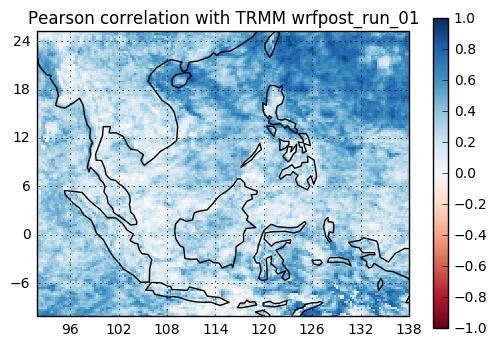

working on../WRF_Parameterization/wrfpost_run_26_2014_d01.nc ../WRF_Parameterization/wrfpost_run_13_2015_d01.nc


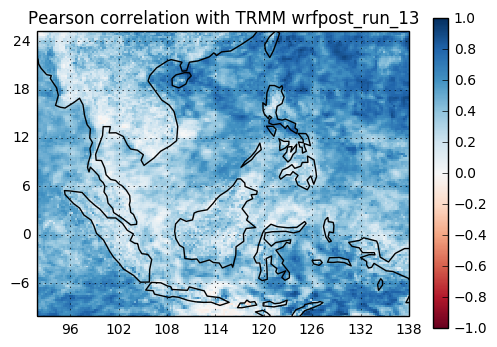

In [3]:
trmm15=xr.open_dataset('../WRF_Parameterization/TRMM_WRFPar2015_Regrid.nc')
trmm14=xr.open_dataset('../WRF_Parameterization/TRMM_WRFPar2014_Regrid.nc')
ti,la,lo=np.shape(trmm14.TRMM)
trmm=np.zeros([184,la,lo])
#collect JJA of both years
trmm[:92,:,:]=trmm14.TRMM[151:243,:,:]
trmm[92:,:,:]=trmm15.TRMM[151:243,:,:]
time,lats,lons=np.shape(trmm)
file_list2014=[]
file_list2015=[]
for name in glob.glob('../WRF_Parameterization/wrfpost_run*_2014_*.nc'):
    file_list2014.append(name)
for name in glob.glob('../WRF_Parameterization/wrfpost_run*_2015_*.nc'):
    file_list2015.append(name)
print(file_list2014,file_list2015)

#rearrange files by number
print('rearranging files')
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

file_list2014.sort(key=natural_keys)
file_list2015.sort(key=natural_keys)
print(file_list2014,file_list2015)

for fileIndex in range(0,len(file_list2014)):
    print('working on'+file_list2014[fileIndex],file_list2015[fileIndex])
    wrf2014=xr.open_dataset(file_list2014[fileIndex])
    wrf2015=xr.open_dataset(file_list2015[fileIndex])
    gridlat=wrf2014.lat
    gridlon=wrf2014.lon
    ppt2014=wrf2014.PPT
    ppt2015=wrf2015.PPT
    ppt=np.zeros([time,lats,lons])
    ppt[:92,:,:]=ppt2014
    ppt[92:,:,:]=ppt2015
    correlation=np.zeros([lats,lons])
    for i in range(0,lats):
        for j in range(0,lons):
            correlation[i,j],b=stats.pearsonr(ppt[:,i,j],trmm[:,i,j])
    #np.save('correlation_'+str(file_list2015[fileIndex])[24:-12],correlation)
    ax=plt.subplot(projection=ccrs.PlateCarree())
    plt.pcolor(gridlon,gridlat,correlation,cmap='RdBu',vmin=-1,vmax=1)
    ax.coastlines()
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
    gl.xlabels_top=False
    gl.ylabels_right=False
    plt.title('Pearson correlation with TRMM '+str(file_list2015[fileIndex])[24:-12])
    plt.colorbar()
    plt.show()
    #plt.savefig('../WRF_Parameterization/ppt_combined_corr'+file_list2015[fileIndex][24:-12]+'.png')
    #plt.close()

## This part collects and plots the correlation data
Loads correlation values saved and compares it to TRMM data over land

In [12]:
def collect_corr(d_num):
    corrlist=[]
    plist=[]
    if d_num==1:
        mapfile=xr.open_dataset('../WRF_Parameterization/wrfpost_run_01_2015_d01.nc')
    else:
        mapfile=xr.open_dataset('../WRF_Parameterization/trmm_correlation_d02/wrfpost_run_01_2015_d02_regrid.nc')
    time,lats,lons=np.shape(mapfile.PPT)
    print(time,lats,lons)
    gridlat=mapfile.lat
    gridlon=mapfile.lon
    landmask=mapfile.LANDMASK[0,:,:]
    lanan=mapfile.LANDMASK[0,:,:]
    lanan.data[lanan.data==0]=np.nan
    lanan.data[lanan.data>0]=1
    if d_num==1:
        for name in glob.glob('../WRF_Parameterization/trmm_correlations/correlation_trmm_run*.npy'):
            corrlist.append(name)
    else:
        for name in glob.glob('../WRF_Parameterization/trmm_correlation_d02/corr_trmm_run*d02_regrid.npy'):        
            corrlist.append(name)
    corrlist.sort(key=natural_keys)
    if d_num==1:
        for name in glob.glob('../WRF_Parameterization/trmm_correlations/pvals_trmm_run*.npy'):
            plist.append(name)
    else:
        for name in glob.glob('../WRF_Parameterization/trmm_correlation_d02/pvals_trmm_run*d02_regrid.npy'):
            plist.append(name)
    plist.sort(key=natural_keys)
    print(corrlist)

    count=0
    corrMeanAll=[]
    corrMeanLand=[]
    sigCorrMeanAll=[]
    sigCorrMeanLand=[]
    for filename in corrlist:
    #    print(filename[-10:-4])
    #    print(filename[-17:-4])
        corr=[np.load(corrlist[count])]
        pval=[np.load(plist[count])] #load pvalues
        sigallmsk=np.empty([lats,lons])
        sigallmsk=np.array(pval)<0.05 #find all values with p<0.05
        sigall=sigallmsk*corr
        print('negative corr vals is '+str((sigall < 0).sum()))
        sigallmean=np.nansum(sigall)/np.nansum(sigall != 0)
        sigCorrMeanAll.append(sigallmean)
        mskpval=pval*lanan.data
        mskcorr=corr*landmask.data
        sigmsk=np.empty([lats,lons])
        sigmsk=mskpval<0.05
        sigcorr=sigmsk[0,:,:]*np.asarray(corr)[0,:,:]
    #     plt.figure(count)
    #     plt.subplot(projection=ccrs.PlateCarree())
    #     plt.pcolor(gridlon,gridlat,sigall[0,:,:],vmin=0,vmax=1)
    #     plt.colorbar()
    #     ax=plt.gca()
    #     ax.coastlines()
        sigcorrmean=np.nansum(sigcorr)/np.nansum(sigcorr != 0)
        sigCorrMeanLand.append(sigcorrmean)
        overallMean=np.nanmean(np.nanmean(corr))
        overallMeanLand=np.nansum(mskcorr)/np.nansum((mskcorr != 0))
        corrMeanAll.append(overallMean)
        corrMeanLand.append(overallMeanLand)
        print('Average correlation overall is '+ str(overallMean))
        print("Average correlation over land is "+ str(overallMeanLand))
        print('Ave significant correlation overall is '+ str(sigallmean)+ ' over '+str((sigall != 0).sum()))
        print('Ave significant correlation over land is '+str(sigcorrmean)+ ' over '+str((sigcorr != 0).sum()))
        count=count+1
    corrMeanAll.insert(12,0)
    corrMeanAll.insert(14,0)
    corrMeanLand.insert(12,0)
    corrMeanLand.insert(14,0)
    sigCorrMeanLand.insert(12,0)
    sigCorrMeanLand.insert(14,0)
    sigCorrMeanAll.insert(12,0)
    sigCorrMeanAll.insert(14,0)
    return corrMeanAll,corrMeanLand,sigCorrMeanAll,sigCorrMeanLand

corrMeanAll,corrMeanLand,sigCorrMeanAll,sigCorrMeanLand=collect_corr(1)
corrMeanAll_d02,corrMeanLand_d02,sigCorrMeanAll_d02,sigCorrMeanLand_d02=collect_corr(2)

92 149 189
['../WRF_Parameterization/trmm_correlations/correlation_trmm_run_01.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_02.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_03.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_04.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_05.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_06.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_07.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_08.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_09.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_10.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_11.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_12.npy', '../WRF_Parameterization/trmm_correlations/correlation_trmm_run_13.npy', '../WRF_Parameterization/trmm_correlati

/Users/likkhian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in greater
/Users/likkhian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in less
/Users/likkhian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in less


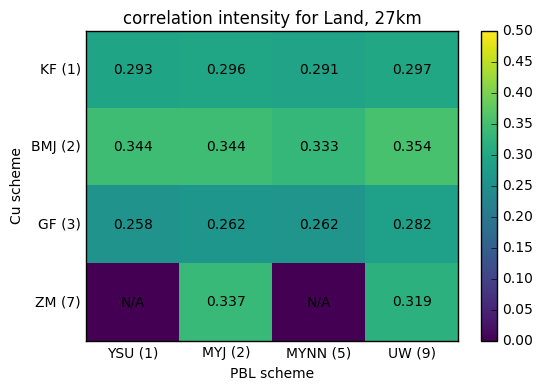

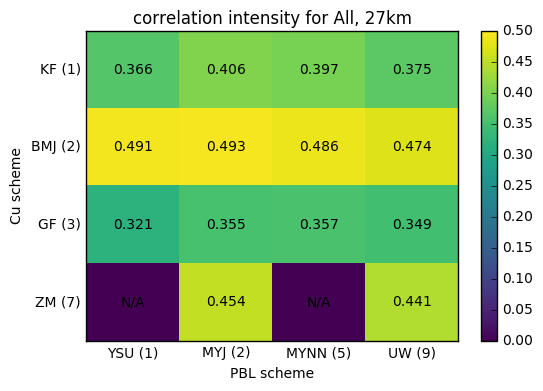

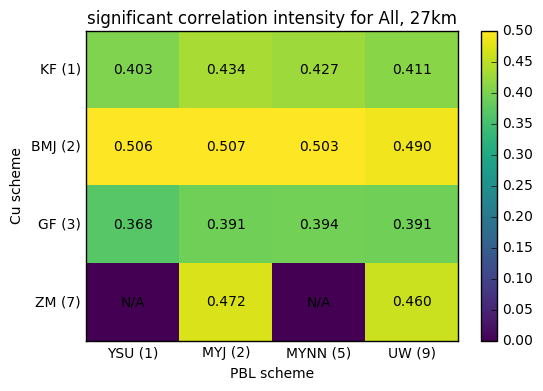

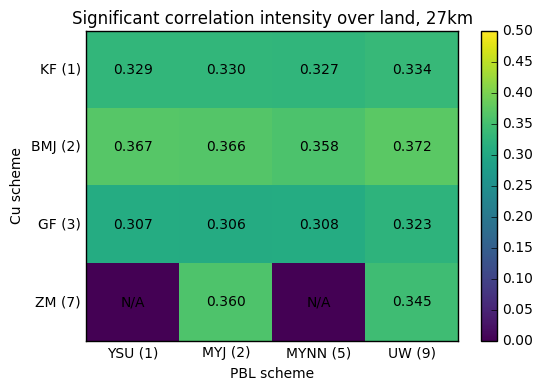

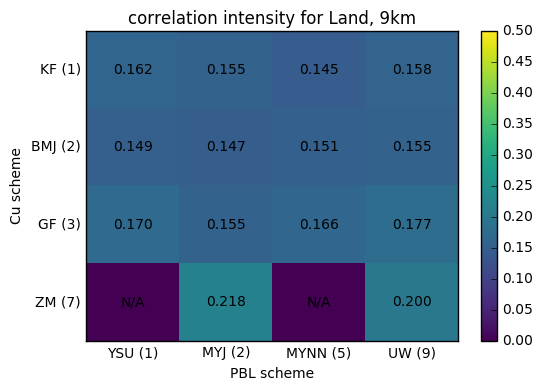

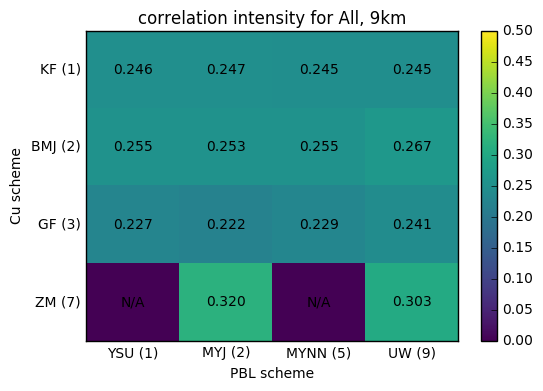

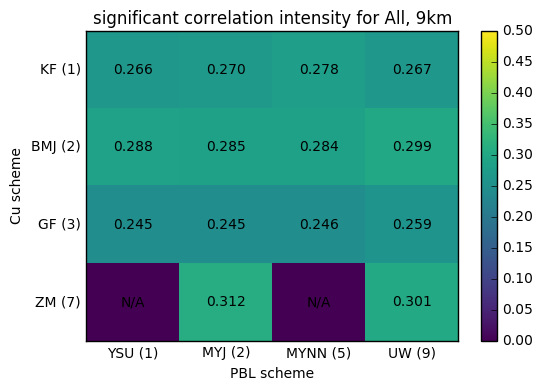

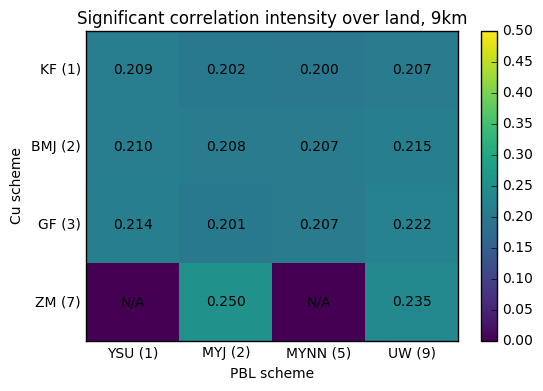

In [13]:
def compareMatrix(allArray):
    ax=plt.gca()
    for (i, j), z in np.ndenumerate(allArray):
        if((i==3 and j==0) or (i==3 and j==2)):
            ax.text(j+0.5,i+0.5,'N/A', ha='center', va='center')#,\
                    #bbox=dict(boxstyle='round', facecolor='white', edgecolor='1',pad=0.1))
        else:
            ax.text(j+0.5, i+0.5, '{:0.3f}'.format(z), ha='center', va='center')#,\
                    #bbox=dict(boxstyle='round', facecolor='white', edgecolor='1',pad=0.1))
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_locator(ticker.FixedLocator(mx))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(['YSU (1)','MYJ (2)','MYNN (5)','UW (9)']))
    plt.xlabel('PBL scheme')
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_minor_locator(ticker.FixedLocator(my))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(['KF (1)','BMJ (2)','GF (3)','ZM (7)']))
    plt.ylabel('Cu scheme')
    plt.colorbar()
    plt.gca().invert_yaxis()



    
x=y=[0,1,2,3,4]
mx=my=[0.5,1.5,2.5,3.5]
labelx=['a','b','c','d']

landArray=np.array(corrMeanLand).reshape(4,4)
plt.figure(1)
plt.pcolormesh(y,x,landArray,cmap='viridis',vmin=0,vmax=0.5)
plt.title('correlation intensity for Land, 27km')
compareMatrix(landArray)

allArray=np.array(corrMeanAll).reshape(4,4)
plt.figure(2)
plt.pcolormesh(allArray,cmap='viridis',vmin=0,vmax=0.5)
plt.title('correlation intensity for All, 27km')
compareMatrix(allArray)

CorrLandArray=np.array(sigCorrMeanAll).reshape(4,4)
plt.figure(3)
plt.pcolormesh(CorrLandArray,cmap='viridis',vmin=0,vmax=0.5)
plt.title('significant correlation intensity for All, 27km')
compareMatrix(CorrLandArray)

CorrLandArray=np.array(sigCorrMeanLand).reshape(4,4)
plt.figure(4)
plt.pcolormesh(CorrLandArray,cmap='viridis',vmin=0,vmax=0.5)
plt.title('Significant correlation intensity over land, 27km')
compareMatrix(CorrLandArray)

#plot d02 vals

landArray=np.array(corrMeanLand_d02).reshape(4,4)
plt.figure(5)
plt.pcolormesh(y,x,landArray,cmap='viridis',vmin=0,vmax=0.5)
plt.title('correlation intensity for Land, 9km')
compareMatrix(landArray)

allArray=np.array(corrMeanAll_d02).reshape(4,4)
plt.figure(6)
plt.pcolormesh(allArray,cmap='viridis',vmin=0,vmax=0.5)
plt.title('correlation intensity for All, 9km')
compareMatrix(allArray)

CorrLandArray=np.array(sigCorrMeanAll_d02).reshape(4,4)
plt.figure(7)
plt.pcolormesh(CorrLandArray,cmap='viridis',vmin=0,vmax=0.5)
plt.title('significant correlation intensity for All, 9km')
compareMatrix(CorrLandArray)

CorrLandArray=np.array(sigCorrMeanLand_d02).reshape(4,4)
plt.figure(8)
plt.pcolormesh(CorrLandArray,cmap='viridis',vmin=0,vmax=0.5)
plt.title('Significant correlation intensity over land, 9km')
compareMatrix(CorrLandArray)

/Users/likkhian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


<class 'list'>
(149, 189)
0.336018922948
28161
<xarray.DataArray 'LANDMASK' ()>
array(7206.0)
Coordinates:
    time     datetime64[ns] 2015-06-01


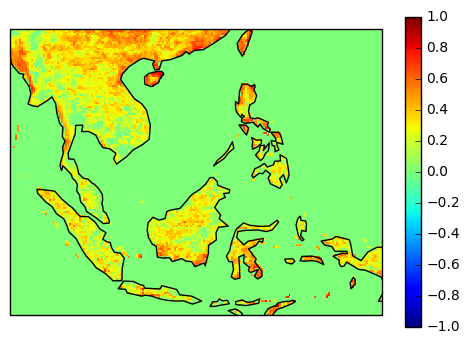

In [9]:
#look at pvalues
pval=np.load('../WRF_Parameterization/trmm_correlations/pvals_trmm_run_13.npy')
landmask.data[landmask.data==0]=np.nan
mskpval=pval*landmask.data


sigmsk=np.empty([lats,lons])
sigmsk=mskpval<0.05

print(type(corr))
sigcorr=sigmsk*np.asarray(corr)[0,:,:]
print(np.shape(sigcorr))

plt.subplot(projection=ccrs.PlateCarree())
plt.pcolor(gridlon,gridlat,sigcorr,vmin=-1,vmax=1)
plt.colorbar()
ax=plt.gca()
ax.coastlines()
corrmean=sigcorr.sum()/(sigcorr != 0).sum()
print(corrmean)
print(lats*lons)
print(landmask.sum())

In [6]:
# import numpy as np
# from scipy.io import savemat 

# savemat('./../WRF_Parameterization/sigCorrMeanLandd02.mat',dict(d02=sigCorrMeanLand))



# for wrfchem runs

In [14]:
corrlist=[]
plist=[]
mapfile=xr.open_dataset('../WRF_Parameterization/fwwrfchemruns/wrfpost_par2_d01_d01.nc')
# mapfile=xr.open_dataset('../WRF_Parameterization/fwwrfchemruns/wrfpost_par2_2015_d02_regrid.nc')
# mapfile=xr.open_dataset('../WRF_Parameterization/trmm_correlation_d02/wrfpost_run_01_2015_d02_regrid.nc')
time,lats,lons=np.shape(mapfile.PPT)
print(time,lats,lons)
gridlat=mapfile.lat
gridlon=mapfile.lon
landmask=mapfile.LANDMASK[0,:,:]
lanan=mapfile.LANDMASK[0,:,:]
lanan.data[lanan.data==0]=np.nan
lanan.data[lanan.data>0]=1
# for name in glob.glob('../WRF_Parameterization/trmm_correlation_d02/corr_trmm_run*d02_regrid.npy'):
# for name in glob.glob('../WRF_Parameterization/trmm_correlations/correlation_trmm_run*.npy'):
# for name in glob.glob('../WRF_Parameterization/fwwrfchemruns/corr_trmm_par*d02_regrid.npy'):
for name in glob.glob('../WRF_Parameterization/fwwrfchemruns/corr_trmm_par*d01.npy'):
    corrlist.append(name)
corrlist.sort(key=natural_keys)
# for name in glob.glob('../WRF_Parameterization/trmm_correlation_d02/pvals_trmm_run*d02_regrid.npy'):
# for name in glob.glob('../WRF_Parameterization/trmm_correlations/pvals_trmm_run*.npy'):
# for name in glob.glob('../WRF_Parameterization/fwwrfchemruns/pvals_trmm_par*d02_regrid.npy'):
for name in glob.glob('../WRF_Parameterization/fwwrfchemruns/pvals_trmm_par*d01.npy'):
    plist.append(name)
plist.sort(key=natural_keys)

print(corrlist)
count=0
corrMeanAll=[]
corrMeanLand=[]
sigCorrMeanAll=[]
sigCorrMeanLand=[]
for filename in corrlist:
#    print(filename[-10:-4])
#    print(filename[-17:-4])
    corr=[np.load(corrlist[count])]
    pval=[np.load(plist[count])] #load pvalues
#     print(corr,pval)
    sigallmsk=np.zeros([lats,lons])
    sigallmsk=np.array(pval)<=0.05 #find all values with p<0.05
    sigall=sigallmsk*corr
    print('negative corr vals is '+str((sigall < 0).sum()))
    sigallmean=np.nansum(sigall)/np.nansum(sigall != 0)
#     sigall[sigall == 0] = np.nan
#     sigallmean=np.nanmean(sigall)
    sigCorrMeanAll.append(sigallmean)
    mskpval=pval*lanan.data
    mskcorr=corr*landmask.data
    sigmsk=np.empty([lats,lons])
    sigmsk=mskpval<0.05
    sigcorr=sigmsk[0,:,:]*np.asarray(corr)[0,:,:]
#     plt.figure(count)
#     plt.subplot(projection=ccrs.PlateCarree())
#     plt.pcolor(gridlon,gridlat,sigall[0,:,:],vmin=0,vmax=1)
#     plt.colorbar()
#     ax=plt.gca()
#     ax.coastlines()
    sigcorrmean=np.nansum(sigcorr)/np.nansum(sigcorr != 0)
    sigCorrMeanLand.append(sigcorrmean)
    overallMean=np.nanmean(np.nanmean(corr))
    overallMeanLand=np.nansum(mskcorr)/np.nansum((mskcorr != 0))
    corrMeanAll.append(overallMean)
    corrMeanLand.append(overallMeanLand)
    print('Average correlation overall is '+ str(overallMean))
    print("Average correlation over land is "+ str(overallMeanLand))
    print('Ave significant correlation overall is '+ str(sigallmean)+ ' over '+str((sigall != 0).sum()))
    print('Ave significant correlation over land is '+str(sigcorrmean)+ ' over '+str((sigcorr != 0).sum()))
    count=count+1
    

31 149 189
['../WRF_Parameterization/fwwrfchemruns/corr_trmm_par2_2015_d01.npy', '../WRF_Parameterization/fwwrfchemruns/corr_trmm_par3_2015_d01.npy', '../WRF_Parameterization/fwwrfchemruns/corr_trmm_par4_2015_d01.npy']
negative corr vals is 0
Average correlation overall is 0.3476692043497157
Average correlation over land is 0.2879315002384605
Ave significant correlation overall is 0.4957594438104565 over 17581
Ave significant correlation over land is 0.43472470273835173 over 3848
negative corr vals is 0
Average correlation overall is 0.4720982850665332
Average correlation over land is 0.37181301726490595
Ave significant correlation overall is 0.5581875073755007 over 22644
Ave significant correlation over land is 0.4670585257620701 over 5122
negative corr vals is 1
Average correlation overall is 0.4828698118880542
Average correlation over land is 0.35454921046635535
Ave significant correlation overall is 0.5677303138250264 over 22817
Ave significant correlation over land is 0.4614978148

/Users/likkhian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/Users/likkhian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in less


In [10]:
print(sigcorr)

[[        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan  0.         ...,  0.                 nan
          nan]
 [        nan         nan  0.         ...,  0.                 nan
          nan]
 ..., 
 [        nan         nan  0.         ...,  0.7891362          nan
          nan]
 [        nan         nan -0.         ...,  0.72000295         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]]
